In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, RobustScaler, FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

sns.set()

## 1. Load Dataset

In [2]:
df = pd.read_csv("games.csv")
df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB


## 2. EDA

In [4]:
# Check number of null values of each column
df.isna().sum()

id                0
rated             0
created_at        0
last_move_at      0
turns             0
victory_status    0
winner            0
increment_code    0
white_id          0
white_rating      0
black_id          0
black_rating      0
moves             0
opening_eco       0
opening_name      0
opening_ply       0
dtype: int64

In [5]:
# Convert created_at and last_move_at from float to datetime
df['created_at']    = pd.to_datetime(df['created_at']/1000,  unit='s',  origin='unix')
df['last_move_at']  = pd.to_datetime(df['last_move_at']/1000,  unit='s',  origin='unix')
df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,2017-08-31 20:06:40,2017-08-31 20:06:40,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,2017-08-30 21:53:20,2017-08-30 21:53:20,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,2017-08-30 21:53:20,2017-08-30 21:53:20,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,2017-08-30 16:20:00,2017-08-30 16:20:00,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,2017-08-29 18:06:40,2017-08-29 18:06:40,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [6]:
print(f"Dates are equal: {(df['created_at'] == df['last_move_at']).sum()} instances")
print(f"Dates are not equal: {(df['created_at'] != df['last_move_at']).sum()} instances")

Dates are equal: 8548 instances
Dates are not equal: 11510 instances


In [7]:
# Get the amount of time each match takes
df['duration'] = (df['last_move_at'] - df['created_at']).dt.total_seconds()
df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,duration
0,TZJHLljE,False,2017-08-31 20:06:40,2017-08-31 20:06:40,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,0.0
1,l1NXvwaE,True,2017-08-30 21:53:20,2017-08-30 21:53:20,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,0.0
2,mIICvQHh,True,2017-08-30 21:53:20,2017-08-30 21:53:20,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3,0.0
3,kWKvrqYL,True,2017-08-30 16:20:00,2017-08-30 16:20:00,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3,0.0
4,9tXo1AUZ,True,2017-08-29 18:06:40,2017-08-29 18:06:40,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5,0.0


In [8]:
df['duration'].value_counts()

0.000        8548
10000.000     734
1233.139        3
260.178         3
1000.942        3
             ... 
956.946         1
142.205         1
636.600         1
204.020         1
736.699         1
Name: duration, Length: 10338, dtype: int64

It seems that the timestamps for created_at and last_move_at are highly inaccurate. This is because in over 80% of instances, there is no time difference between created_at and last_move_at.

Therefore, we will drop all these columns since they are unusable.

In [9]:
df.drop(columns=['created_at', 'last_move_at', 'duration'], inplace=True)

In [10]:
# Extract increment code to get start time limit (mins) and increment (secs)
inc_extracted = df['increment_code'].str.split("+")
df['start_time_limit'] = [int(x[0]) for x in inc_extracted]
df['increment'] = [int(x[1]) for x in inc_extracted]
df.drop(columns='increment_code', inplace=True)

In [11]:
# Get list of moves per match and extract first moves of white and black players
df['moves_list'] = df['moves'].str.split(" ")
df['white_first_move'] = [x[0] for x in df['moves_list']]
df['black_first_move'] = [x[1] if len(x)>=2 else None for x in df['moves_list']]
df.drop(columns='moves', inplace=True)

In [12]:
# Find the differences in terms of ratings between black and white player
# Positive value: white rating > black rating
# Negative value: white rating < black rating
df['rating_diff'] = df['white_rating'] - df['black_rating']

In [13]:
df.head()

,id,rated,turns,victory_status,winner,white_id,white_rating,black_id,black_rating,opening_eco,opening_name,opening_ply,start_time_limit,increment,moves_list,white_first_move,black_first_move,rating_diff
0,TZJHLljE,False,13,outoftime,white,bourgris,1500,a-00,1191,D10,Slav Defense: Exchange Variation,5,15,2,"[d4, d5, c4, c6, cxd5, e6, dxe6, fxe6, Nf3, Bb...",d4,d5,309
1,l1NXvwaE,True,16,resign,black,a-00,1322,skinnerua,1261,B00,Nimzowitsch Defense: Kennedy Variation,4,5,10,"[d4, Nc6, e4, e5, f4, f6, dxe5, fxe5, fxe5, Nx...",d4,Nc6,61
2,mIICvQHh,True,61,mate,white,ischia,1496,a-00,1500,C20,King's Pawn Game: Leonardis Variation,3,5,10,"[e4, e5, d3, d6, Be3, c6, Be2, b5, Nd2, a5, a4...",e4,e5,-4
3,kWKvrqYL,True,61,mate,white,daniamurashov,1439,adivanov2009,1454,D02,Queen's Pawn Game: Zukertort Variation,3,20,0,"[d4, d5, Nf3, Bf5, Nc3, Nf6, Bf4, Ng4, e3, Nc6...",d4,d5,-15
4,9tXo1AUZ,True,95,mate,white,nik221107,1523,adivanov2009,1469,C41,Philidor Defense,5,30,3,"[e4, e5, Nf3, d6, d4, Nc6, d5, Nb4, a3, Na6, N...",e4,e5,54


In [14]:
print(f"Number of unique white players: {len(df['white_id'].unique())}")
print(f"Number of unique black players: {len(df['black_id'].unique())}")
print(f"Number of unique players: {len(set(df['white_id'].unique()) | set(df['black_id'].unique()))}")
print(f"Number of unique players who had played both black and white: {len(set(df['white_id'].unique()) & set(df['black_id'].unique()))}")

Number of unique white players: 9438
Number of unique black players: 9331
Number of unique players: 15635
Number of unique players who had played both black and white: 3134


In [15]:
df['opening_name'].value_counts()

Van't Kruijs Opening                                              368
Sicilian Defense                                                  358
Sicilian Defense: Bowdler Attack                                  296
Scotch Game                                                       271
French Defense: Knight Variation                                  271
                                                                 ... 
Sicilian Defense: Kupreichik Variation                              1
Modern Defense: Lizard Defense |  Mittenberger Gambit               1
French Defense: Rubinstein Variation |  Kasparov Attack             1
French Defense: Tarrasch Variation |  Open System |  Main Line      1
Sicilian Defense: Najdorf Variation |  Polugaevsky Variation        1
Name: opening_name, Length: 1477, dtype: int64

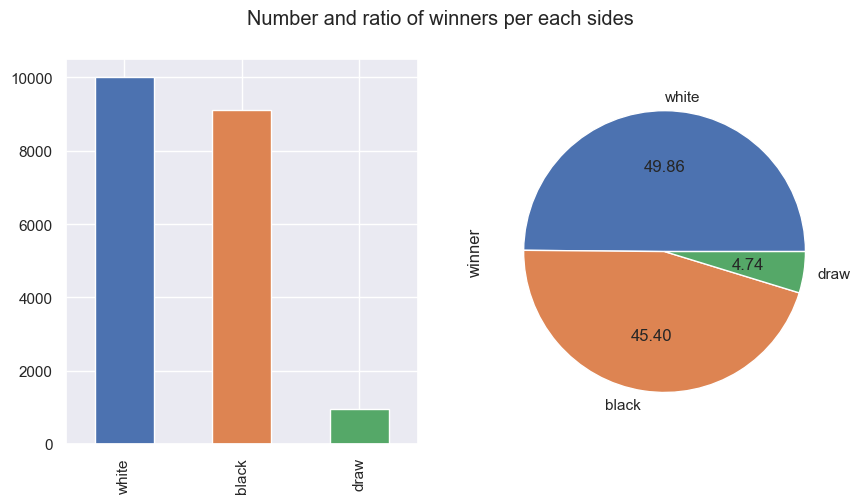

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
df['winner'].value_counts().plot.bar(color=sns.color_palette(), ax=axs[0])
df['winner'].value_counts().plot.pie(autopct='%.2f', ax=axs[1])
fig.suptitle("Number and ratio of winners per each sides")
plt.show()

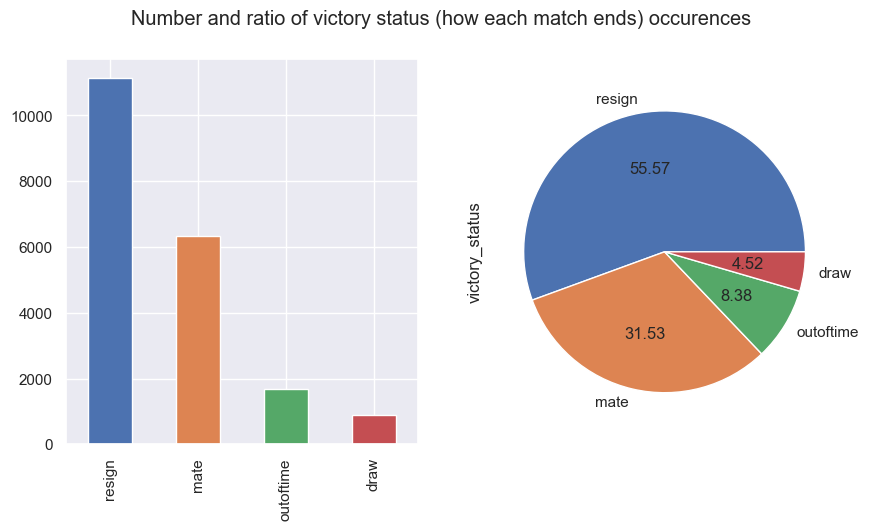

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
df['victory_status'].value_counts().plot.bar(color=sns.color_palette(), ax=axs[0])
df['victory_status'].value_counts().plot.pie(autopct='%.2f', ax=axs[1])
fig.suptitle("Number and ratio of victory status (how each match ends) occurences")
plt.show()

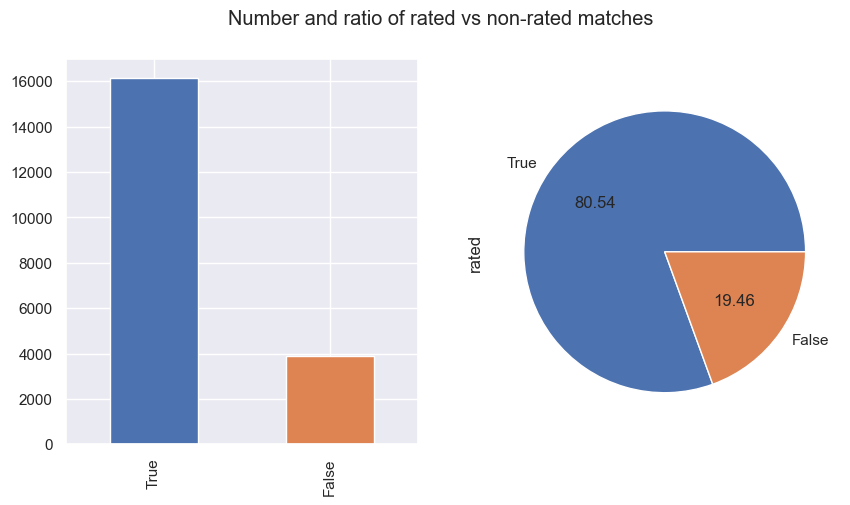

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
df['rated'].value_counts().plot.bar(color=sns.color_palette(), ax=axs[0])
df['rated'].value_counts().plot.pie(autopct='%.2f', ax=axs[1])
fig.suptitle("Number and ratio of rated vs non-rated matches")
plt.show()

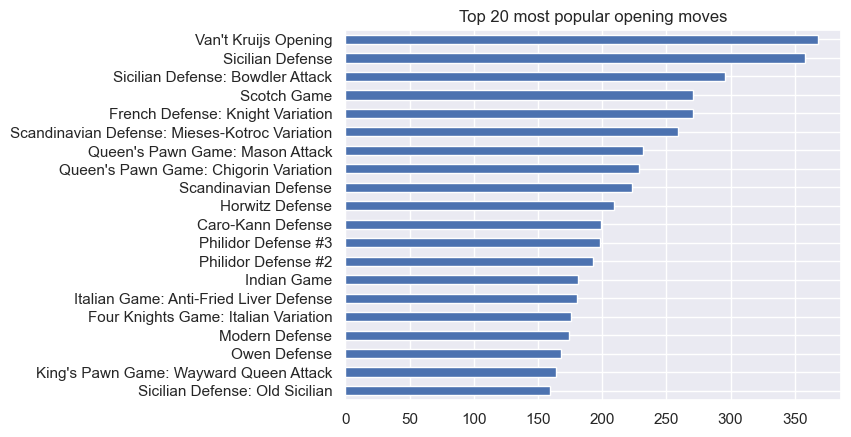

In [19]:
df['opening_name'].value_counts()[:20].sort_values().plot.barh()
plt.title("Top 20 most popular opening moves")
plt.show()

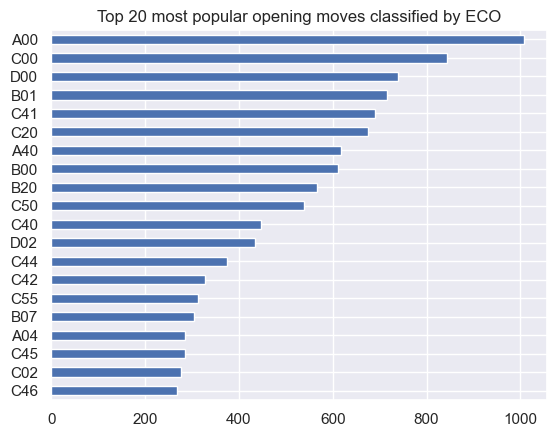

In [20]:
df['opening_eco'].value_counts()[:20].sort_values().plot.barh()
plt.title("Top 20 most popular opening moves classified by ECO")
plt.show()

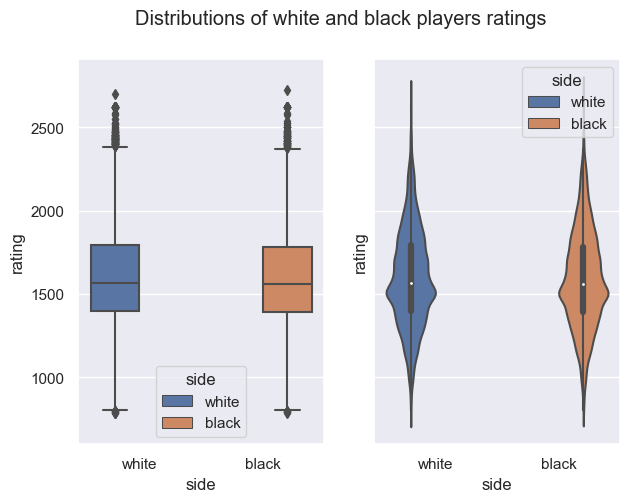

In [21]:
white_ratings = df[['white_rating']].copy().rename(columns={'white_rating': 'rating'})
white_ratings['side'] = 'white'

black_ratings = df[['black_rating']].copy().rename(columns={'black_rating': 'rating'})
black_ratings['side'] = 'black'

ratings = pd.concat([white_ratings, black_ratings]).reset_index(drop=True)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(7,5))
sns.boxplot(data=ratings, x='side', y='rating', hue='side', ax=axs[0])
sns.violinplot(data=ratings, x='side', y='rating', hue='side', ax=axs[1])
fig.suptitle("Distributions of white and black players ratings")
plt.setp(axs, ylim=axs[0].get_ylim())
plt.show()

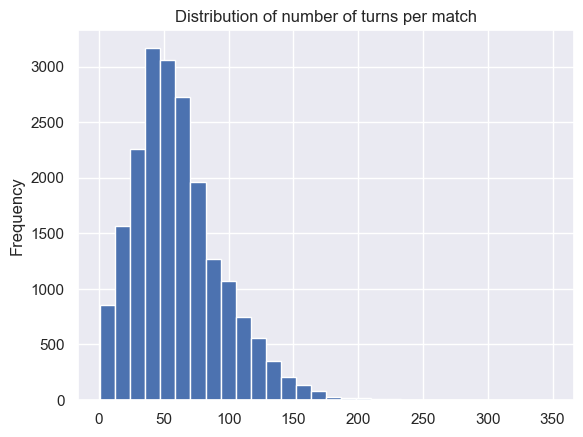

In [22]:
df['turns'].plot.hist(bins=30)
plt.title('Distribution of number of turns per match')
plt.show()

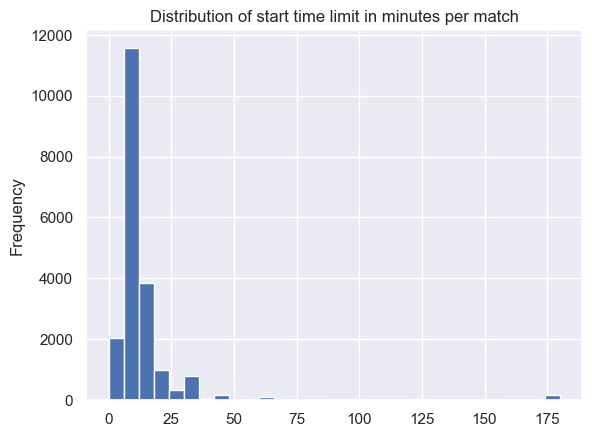

In [23]:
df['start_time_limit'].plot.hist(bins=30)
plt.title('Distribution of start time limit in minutes per match')
plt.show()

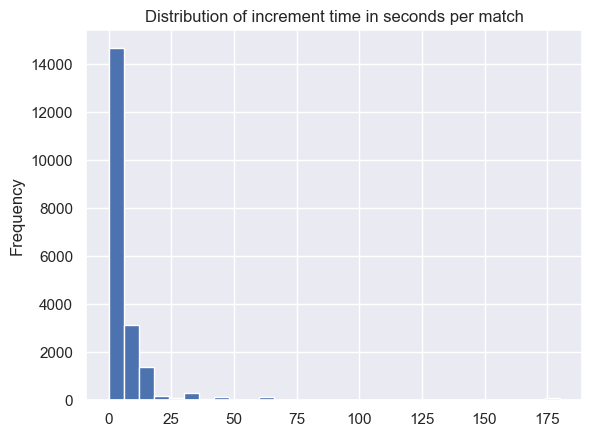

In [24]:
df['increment'].plot.hist(bins=30)
plt.title('Distribution of increment time in seconds per match')
plt.show()

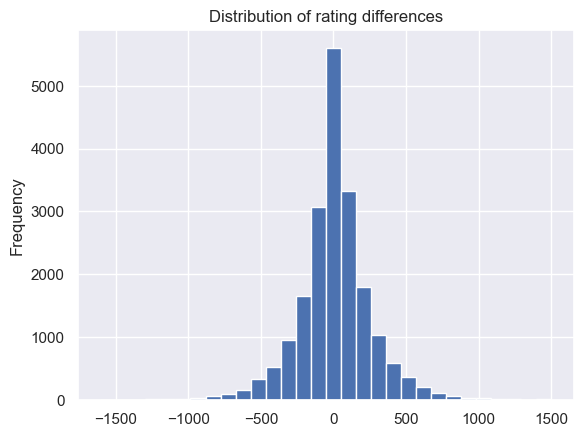

In [25]:
df['rating_diff'].plot.hist(bins=30)
plt.title('Distribution of rating differences')
plt.show()

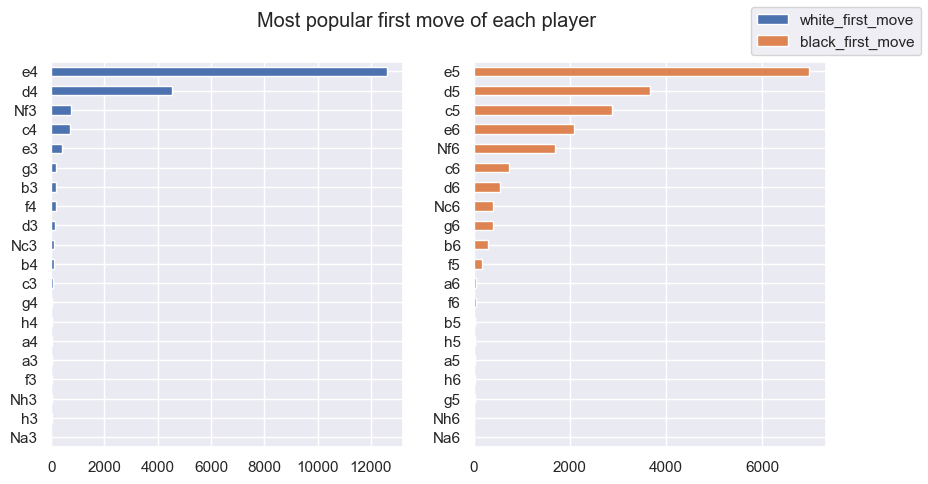

In [26]:
# In chess game, there are only 20 possible first moves for each side (16 pawn moves and 4 knight moves)
fig, axs = plt.subplots(1, 2, figsize=(10,5))
df['white_first_move'].value_counts().sort_values().plot.barh(ax=axs[0], color=sns.color_palette()[0])
df['black_first_move'].value_counts().sort_values().plot.barh(ax=axs[1], color=sns.color_palette()[1])
fig.suptitle("Most popular first move of each player")
fig.legend()
plt.show()

In [27]:
df_player = pd.DataFrame({"player_id": list(set(df['white_id'].unique()) | set(df['black_id'].unique()))})

# Get only matches in which black wins
black_win = df[df['winner'] == 'black']
white_win = df[df['winner'] == 'white']
draw = df[df['winner'] == 'draw']

# Get number of matches that a player participated
df_player['matches_participated'] = df_player['player_id'].map(
    df['white_id'].value_counts().add(df['black_id'].value_counts(), fill_value=0))

# Get number of wins per each player when playing as black, white, overall
df_player['wins_as_black'] = df_player['player_id'].map(black_win['black_id'].value_counts()).fillna(0)
df_player['wins_as_white'] = df_player['player_id'].map(white_win['white_id'].value_counts()).fillna(0)
df_player['wins'] = df_player['wins_as_black'] + df_player['wins_as_white']
df_player['draws'] = df_player['player_id'].map(
    (draw['white_id'].value_counts() + draw['black_id'].value_counts())).fillna(0)
df_player['losses'] = df_player['matches_participated'] - df_player['wins'] - df_player['draws']

# Wins to matches participated ratio
df_player['wins_percentage'] = df_player['wins'] / df_player['matches_participated']
df_player.set_index('player_id', inplace=True)
df_player.head(10)

,matches_participated,wins_as_black,wins_as_white,wins,draws,losses,wins_percentage
player_id,,,,,,,
hunter0961,1.0,0.0,0.0,0.0,0.0,1.0,0.0
micmeta,1.0,0.0,0.0,0.0,0.0,1.0,0.0
fitricter,1.0,0.0,1.0,1.0,0.0,0.0,1.0
ayungputra,1.0,1.0,0.0,1.0,0.0,0.0,1.0
qnhan1111,1.0,0.0,0.0,0.0,0.0,1.0,0.0
nooberdog,1.0,0.0,1.0,1.0,0.0,0.0,1.0
eliseoo23,1.0,0.0,0.0,0.0,0.0,1.0,0.0
kjaliner,2.0,0.0,0.0,0.0,0.0,2.0,0.0
thenextbattle,2.0,0.0,1.0,1.0,0.0,1.0,0.5


In [28]:
top_players = df_player.sort_values('wins', ascending=False)

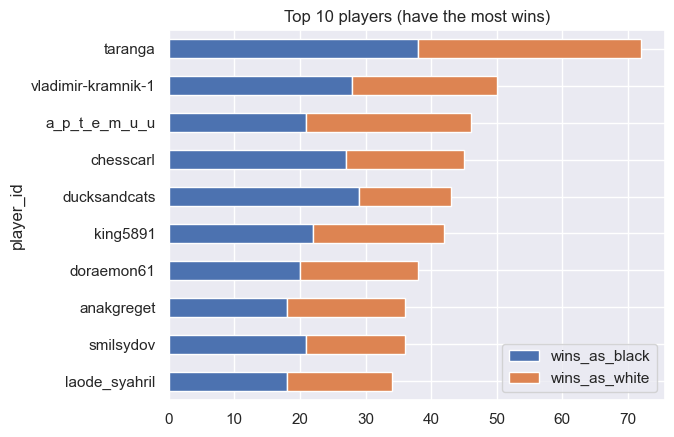

In [29]:
top_players[['wins_as_black', 'wins_as_white']][:10][::-1].plot.barh(stacked=True)
plt.title("Top 10 players (have the most wins)")
plt.show()

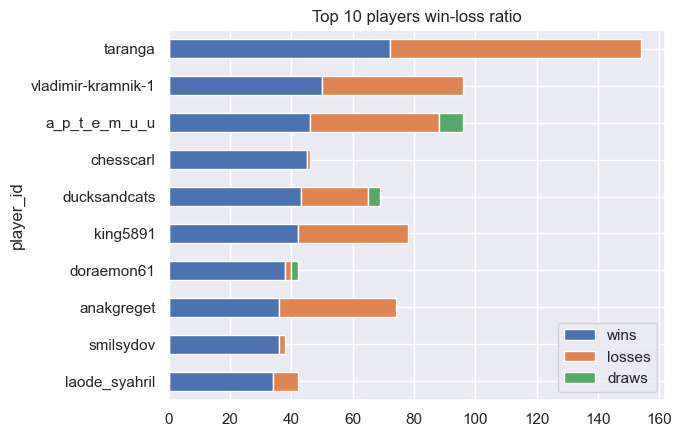

In [30]:
top_players[['wins', 'losses', 'draws']][:10][::-1].plot.barh(stacked=True)
plt.title("Top 10 players win-loss ratio")
plt.show()

## 3. Features Selection
First, we will select subset of matches which did not end in draw.

Next, we exclude matches that ended in one move (black did not move and withdraw)

We will define all features which will be used for chess winning rate predictions.

Features should include all metagame data such as player ratings, start time limit and increments, each player first move, etc.

Features should exclude post-match data such as number of turns and victory status.

In [31]:
# Select subset of matches that do not end in draw and last more than or equal to two turns
subset = df[(df['winner'] != 'draw') & 
            (df['black_first_move'].notna())].copy().reset_index(drop=True)
subset.head()

,id,rated,turns,victory_status,winner,white_id,white_rating,black_id,black_rating,opening_eco,opening_name,opening_ply,start_time_limit,increment,moves_list,white_first_move,black_first_move,rating_diff
0,TZJHLljE,False,13,outoftime,white,bourgris,1500,a-00,1191,D10,Slav Defense: Exchange Variation,5,15,2,"[d4, d5, c4, c6, cxd5, e6, dxe6, fxe6, Nf3, Bb...",d4,d5,309
1,l1NXvwaE,True,16,resign,black,a-00,1322,skinnerua,1261,B00,Nimzowitsch Defense: Kennedy Variation,4,5,10,"[d4, Nc6, e4, e5, f4, f6, dxe5, fxe5, fxe5, Nx...",d4,Nc6,61
2,mIICvQHh,True,61,mate,white,ischia,1496,a-00,1500,C20,King's Pawn Game: Leonardis Variation,3,5,10,"[e4, e5, d3, d6, Be3, c6, Be2, b5, Nd2, a5, a4...",e4,e5,-4
3,kWKvrqYL,True,61,mate,white,daniamurashov,1439,adivanov2009,1454,D02,Queen's Pawn Game: Zukertort Variation,3,20,0,"[d4, d5, Nf3, Bf5, Nc3, Nf6, Bf4, Ng4, e3, Nc6...",d4,d5,-15
4,9tXo1AUZ,True,95,mate,white,nik221107,1523,adivanov2009,1469,C41,Philidor Defense,5,30,3,"[e4, e5, Nf3, d6, d4, Nc6, d5, Nb4, a3, Na6, N...",e4,e5,54


In [32]:
# We encode the target winner into binary numerical value
# 0: Black is the winner
# 1: White is the winner

target_encoder = LabelEncoder()
subset['winner'] = target_encoder.fit_transform(subset['winner'])
subset['winner']

0        1
1        0
2        1
3        1
4        1
        ..
19085    1
19086    0
19087    1
19088    1
19089    0
Name: winner, Length: 19090, dtype: int32

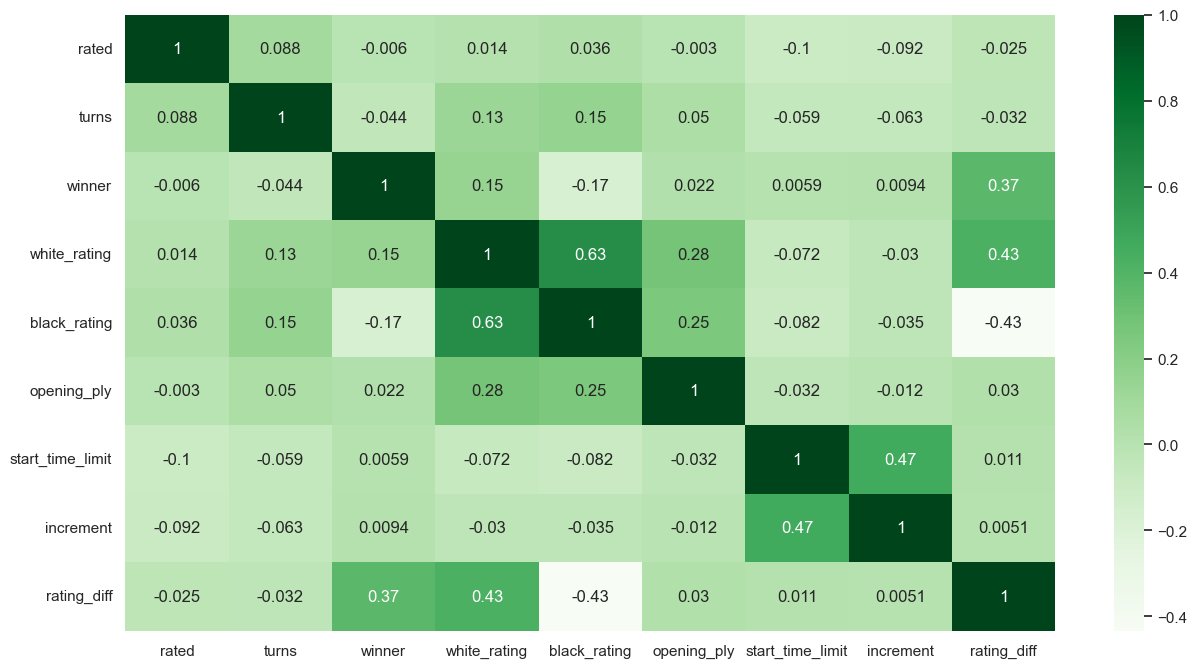

In [33]:
# Show heatmap of correlation matrix
plt.figure(figsize = (15,8))
sns.heatmap(subset.corr(numeric_only=True), annot=True, cmap="Greens")
plt.show()

We can see from the above figure that the most important numeric feature that could be used to predict the winner is "rating_diff".

In [34]:
X = subset[['rated', 'white_rating', 'black_rating', 'start_time_limit',
            'increment', 'white_first_move', 'black_first_move']]
y = subset['winner']
X.shape, y.shape

((19090, 7), (19090,))

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(14317, 7) (4773, 7)
(14317,) (4773,)


## 4. Data Preprocessing
Our preprocessing steps will include the following:

1. Imputers - Although there are no missing values in our selected features, we should consider that once our model has been deployed, users may not have all the necessary information to fill all input values. Therefore, our pipeline should also include the imputers to fill such values from users as well. There are two types of imputers for different types of features:
    1. Numeric Imputer - Fill in missing numerical features with median of the corresponding features.
    2. Categorical Imputer - Fill in missing categorical features with mode of the corresponding features.

2. Feature Engineering - Based on the results obatined from the correlation heatmap, we have determined that "rating_diff" feature should be the most important feature for our predictor. "rating_diff" however is not included in the dataset but must be inferred from "white_rating" and "black_rating" features using our feature engineering transformer.

3. Scaler - Once all numerical features have been obtained (including "rating_diff"), we will apply the Robust Scaler on such feeatures in order to help our model converges faster.

4. Encoder - Transforming all categorical features into numerical representations. We apply different types of encoder methods based on the nature of each feature.
    1. Ordinal Encoder - Encode "rated" feature only since it is a binary feature (True, False).
    2. One-Hot Encoder - Encode "white_first_move" and "black_first_move" since each of these features contains 20 unique values (from the 20 possible first move in chess game) and are nominal in nature thus, it is more appropriate to separate each value into their own columns using One-Hot Encoder.

In [36]:
# Determine which columns should go through which preprocessing steps
num_cols = ['white_rating', 'black_rating', 'start_time_limit', 'increment']
cat_cols = ['rated', 'white_first_move', 'black_first_move']

feat_en_cols = ['white_rating', 'black_rating']
oe_cols = ['rated']
ohe_cols = ['white_first_move', 'black_first_move']

In [37]:
imputers = ColumnTransformer(transformers=[
    ('numeric_imputer', SimpleImputer(missing_values=np.nan, strategy='median'), num_cols),         # Impute using  median for numerical features
    ('categorical_imputer', SimpleImputer(missing_values=None, strategy='most_frequent'), cat_cols) # Impute using mode (most_frequent) for categorical features
    ],
    verbose_feature_names_out=False).set_output(transform='pandas')

In [38]:
# Function for creating the "rating_diff" between white and black ratings
def create_rating_diff(df):
    df = df.copy()
    df['rating_diff'] = df['white_rating'] - df['black_rating']
    return df

In [39]:
transformers = ColumnTransformer(transformers=[
    ('numeric_scaler', RobustScaler(), num_cols+['rating_diff']),   # Robust scaler for numerical features
    ('rated_binary_encoder', OrdinalEncoder(), oe_cols),    # Transform rated feature into binary numerical value (0: False, 1: True)
    ('first_moves_onehot_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ohe_cols)    # We will apply one hot encoding on white_first_move and black_first_move features
    ],  
    verbose_feature_names_out=False,
    remainder='passthrough').set_output(transform='pandas')

In [40]:
# Define our own pipeline of preprocessor
preprocessor = Pipeline(steps=[
    ('imputers', imputers),
    ('feature_engineering', FunctionTransformer(create_rating_diff)),
    ('transformers', transformers)
])

In [41]:
preprocessor.fit_transform(X_train)

,white_rating,black_rating,start_time_limit,increment,rating_diff,rated,white_first_move_Na3,white_first_move_Nc3,white_first_move_Nf3,white_first_move_Nh3,...,black_first_move_d5,black_first_move_d6,black_first_move_e5,black_first_move_e6,black_first_move_f5,black_first_move_f6,black_first_move_g5,black_first_move_g6,black_first_move_h5,black_first_move_h6
7928,-0.345269,-0.380102,-0.6,1.142857,0.064935,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10609,0.035806,-0.002551,0.0,0.000000,0.069264,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13415,-0.161125,-0.040816,0.0,0.714286,-0.199134,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5705,0.322251,0.364796,-1.0,0.857143,-0.069264,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7707,0.795396,0.742347,0.0,0.000000,0.090909,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16332,0.140665,-0.051020,-1.0,0.714286,0.329004,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2341,-0.654731,-0.734694,0.0,0.000000,0.142857,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
17676,0.212276,0.380102,-1.0,1.142857,-0.281385,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8502,0.150895,0.341837,2.0,0.000000,-0.320346,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 5. Model Selection
We will select a set of candidate classifiers and determine which one performs the best using K-fold cross validation.

It is important to consider that since the output we which to obtain is the probabilities of winner for each side, we have to choose the candidate models that can compute for probabilities of each class and not just the labels.

Based on this criteria, we will select the following models: Logistic Regression, Decision Tree, Random Forest, Gradient Boosting.

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [43]:
models = [LogisticRegression(max_iter=5000), DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [44]:
print("=====F1-score=====")
for model in models:
    pipe = make_pipeline(preprocessor, model)
    scores = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring='f1')
    print(f"{model.__class__.__name__} - Score: {scores}; Mean: {scores.mean()}")

=====F1-score=====
LogisticRegression - Score: [0.67284938 0.67662957 0.68540745 0.68978683 0.68344871]; Mean: 0.6816243878198188
DecisionTreeClassifier - Score: [0.61275168 0.61072261 0.62660365 0.60200669 0.62231049]; Mean: 0.6148790233874697
RandomForestClassifier - Score: [0.67137097 0.67578386 0.67461106 0.66796748 0.6647001 ]; Mean: 0.6708866915181653
GradientBoostingClassifier - Score: [0.68429436 0.68434186 0.68811881 0.69387755 0.69417924]; Mean: 0.6889623651110145


In [45]:
print("=====Negative Cross-Entropy Loss=====")
for model in models:
    pipe = make_pipeline(preprocessor, model)
    scores = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring='neg_log_loss')
    print(f"{model.__class__.__name__} - Score: {scores}; Mean: {scores.mean()}")

=====Negative Cross-Entropy Loss=====
LogisticRegression - Score: [-0.61327214 -0.6110554  -0.61730011 -0.61275013 -0.61858001]; Mean: -0.6145915580427912
DecisionTreeClassifier - Score: [-14.28659881 -14.58959606 -14.12833205 -14.78338813 -14.55512237]; Mean: -14.468607485388887
RandomForestClassifier - Score: [-0.62661318 -0.64647225 -0.64511543 -0.63206872 -0.6552976 ]; Mean: -0.6411134342582159
GradientBoostingClassifier - Score: [-0.60991808 -0.60979121 -0.61552652 -0.60679612 -0.61394392]; Mean: -0.6111951696566742


In [46]:
# Select best performing model using default hyperparameters
clf = GradientBoostingClassifier()
best_pipe = make_pipeline(preprocessor, clf)

best_pipe.fit(X_train, y_train)
# Test score of best performing model using default hyperparameters
print(f"Accuracy: {best_pipe.score(X_test, y_test)}")

Accuracy: 0.6515818143725121


## 6. Grid Search and Model Evaluations

In [47]:
# Select best performing model
clf = GradientBoostingClassifier()

# Specify hyperparameters for grid search
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'criterion': ['friedman_mse', 'squared_error'],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
    'max_depth' : [3, 5, 10, 20]}

pipe_grid = {}

# adding the prefix '{classifier_name}__' to each hyperparameter
for param in param_grid.keys():
    new_param = clf.__class__.__name__.lower()+'__'+param
    pipe_grid[new_param] = param_grid[param]


pipe = make_pipeline(preprocessor, clf)
grid = GridSearchCV(pipe, pipe_grid, cv=kfold)
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('imputers',
                                                         ColumnTransformer(transformers=[('numeric_imputer',
                                                                                          SimpleImputer(strategy='median'),
                                                                                          ['white_rating',
                                                                                           'black_rating',
                                                                                           'start_time_limit',
                                                                                           'increment']),
                                                                                         ('categorical_imputer',
                                                                                          SimpleImputer(missing_values=None,
                                                                                                        strategy='most_f...
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             param_grid={'gradientboostingclassifier__criterion': ['friedman_mse',
                                                                   'squared_error'],
                         'gradientboostingclassifier__max_depth': [3, 5, 10,
                                                                   20],
                         'gradientboostingclassifier__min_samples_leaf': [1, 2,
                                                                          3],
                         'gradientboostingclassifier__min_samples_split': [2, 4,
                                                                           6],
                         'gradientboostingclassifier__n_estimators': [10, 50,
                                                                      100,
                                                                      200]})

In [61]:
# Get the best values for each hyperparameter
grid.best_params_

{'gradientboostingclassifier__criterion': 'friedman_mse',
 'gradientboostingclassifier__max_depth': 3,
 'gradientboostingclassifier__min_samples_leaf': 2,
 'gradientboostingclassifier__min_samples_split': 2,
 'gradientboostingclassifier__n_estimators': 50}

In [83]:
best_param = {}
for param in grid.best_params_:
    new_param = param.removeprefix('gradientboostingclassifier__')
    best_param[new_param] = grid.best_params_[param]

# Select best performing model using best hyperparameters
clf = GradientBoostingClassifier(**best_param)
best_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf)])

best_pipe.fit(X_train, y_train)
# Test score of best performing model using best hyperparameters
print(f"Accuracy: {best_pipe.score(X_test, y_test)}")

Accuracy: 0.6511627906976745


In [45]:
results = pd.DataFrame({"actual_winner": y_test})

y_pred = best_pipe.predict(X_test)
results['pred_winner'] = y_pred
results['pred_white_win_rate'] = best_pipe.predict_proba(X_test)[:, 1]
results

,actual_winner,pred_winner,pred_white_win_rate
3535,0,1,0.697732
5453,0,1,0.716740
4185,0,1,0.519940
13875,0,1,0.533355
8062,0,0,0.348476
...,...,...,...
2393,0,0,0.485213
776,0,0,0.463304
3084,1,1,0.680205
15292,1,0,0.423404


In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.54      0.60      2276
           1       0.64      0.75      0.69      2497

    accuracy                           0.65      4773
   macro avg       0.65      0.65      0.64      4773
weighted avg       0.65      0.65      0.65      4773



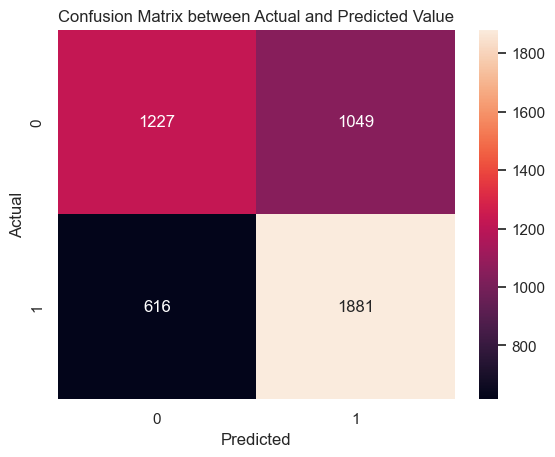

In [53]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("Confusion Matrix between Actual and Predicted Value")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [85]:
# Save the model pipeline
with open('chess_winner_predictor.pkl','wb') as f:
    pickle.dump(best_pipe, f)

In [43]:
# Load the model pipeline
with open('chess_winner_predictor.pkl','rb') as f:
    best_pipe = pickle.load(f)